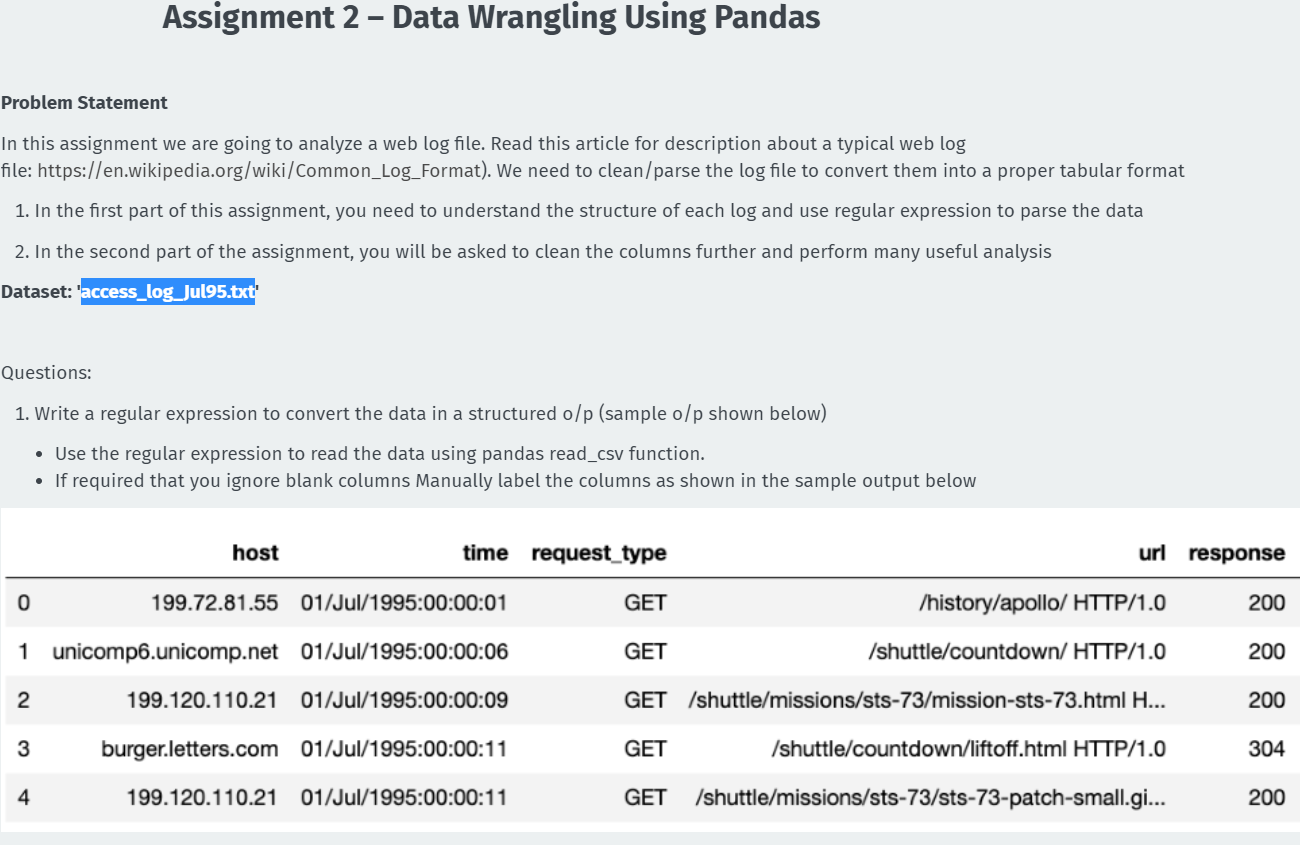

The Common Log Format, also known as the NCSA Common log format (after NCSA_HTTPd) is a standardized text file format used by web servers when generating server log files. Because the format is standardized, the files can be readily analyzed by a variety of web analysis programs.

Each line in a file stored in the Common Log Format has the following syntax:

%c host ident authuser date request status bytes %c

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
%matplotlib inline
import datetime
import re

In [93]:
logs = pd.read_csv('access_log_Jul95.txt', sep='\s+', error_bad_lines=False, header=None, low_memory=False) 

logs.drop([1, 2, 4], axis=1, inplace=True) # drop unwanted columns
logs[3] = logs[3].str.replace('[', '')# split time stamp into two
logs[['Request_Type', 'URL', 'Protocol']] = logs[5].str.split(' ', 2, expand=True)
logs.drop([5, 'Protocol'], axis=1, inplace=True)
logs[['Date', 'Time']] = logs[3].str.split(':', 1, expand=True)
logs.rename(columns = {0:'Host',3:'DateTime', 6:'Response', 7:'Size'}, inplace=True) #rename columns

logs['Response'] = pd.to_numeric(logs['Response']) 
logs.head()

<ipython-input-93-927905ff34ec>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  logs[3] = logs[3].str.replace('[', '')# split time stamp into two


,Host,DateTime,Response,Size,Request_Type,URL,Date,Time
0,199.72.81.55,01/Jul/1995:00:00:01,200,6245,GET,/history/apollo/,01/Jul/1995,00:00:01
1,unicomp6.unicomp.net,01/Jul/1995:00:00:06,200,3985,GET,/shuttle/countdown/,01/Jul/1995,00:00:06
2,199.120.110.21,01/Jul/1995:00:00:09,200,4085,GET,/shuttle/missions/sts-73/mission-sts-73.html,01/Jul/1995,00:00:09
3,burger.letters.com,01/Jul/1995:00:00:11,304,0,GET,/shuttle/countdown/liftoff.html,01/Jul/1995,00:00:11
4,199.120.110.21,01/Jul/1995:00:00:11,200,4179,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,01/Jul/1995,00:00:11


In [148]:
logs.groupby('Size')

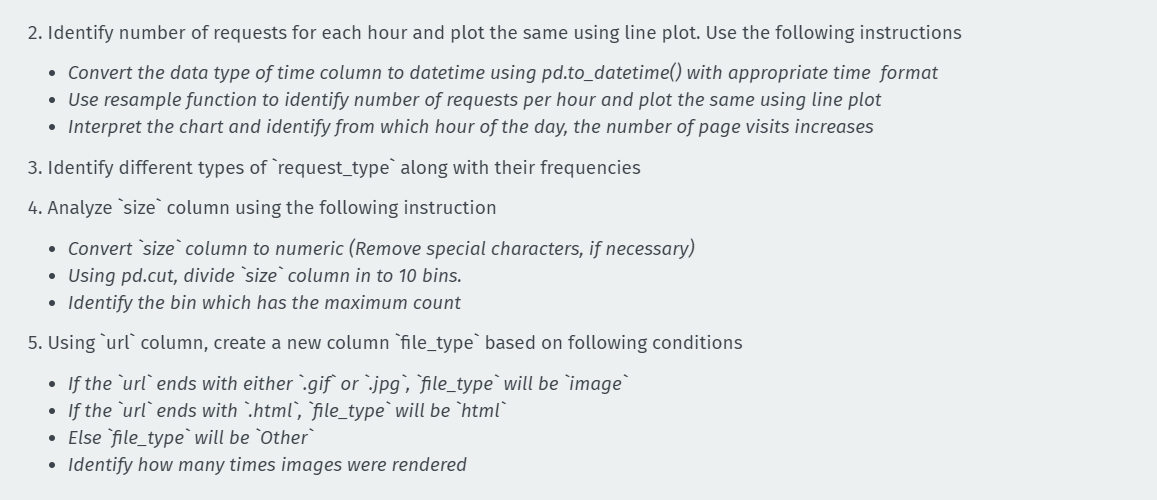

In [22]:
logs['Time'] = pd.to_datetime(logs['Time'])
logs['DateTime'] = pd.to_datetime(logs['DateTime'], format='%d/%b/%Y:%H:%M:%S') # declare data types
sample = logs.set_index('DateTime').resample('H').sum() #identify number of requests per hour
sample.head()

<AxesSubplot:xlabel='DateTime'>

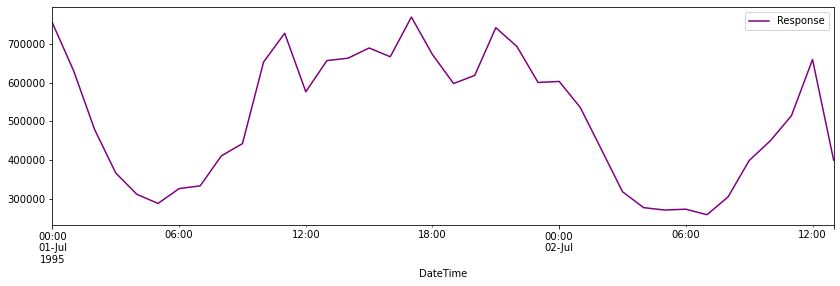

In [23]:
sample.plot.line(figsize=(14,4), color='purple')

The number of page visits increases from 6:00 in the morning and sharply declines after midnight

In [25]:
logs.groupby(['Response']).size() # most resquests are satisfied with a OK response

Response
200    82380
302     3648
304     5235
403        1
404      450
dtype: int64

In [27]:
logs.groupby(['Request_Type']).size()

Request_Type
GET     91639
HEAD       74
POST        1
dtype: int64

In [101]:
logs['Size'].apply(type).value_counts() # checks if all the values in a colums are of the same type.. here not important
logs['Size'] = logs['Size'].str.extract('(\d+)', expand=False) #extract only numeric values from column
logs['Size'] = pd.to_numeric(logs['Size'])
logs['Size'].head(10)

0    6245.0
1    3985.0
2    4085.0
3       0.0
4    4179.0
5       0.0
6       0.0
7    3985.0
8    3985.0
9    7074.0
Name: Size, dtype: float64

In [102]:
pd.cut(logs['Size'], bins=10).value_counts()

# More items fall into (-1646.592, 164659.2] bin

(-1646.592, 164659.2]     88554
(164659.2, 329318.4]       1283
(823296.0, 987955.2]        373
(493977.6, 658636.8]        205
(987955.2, 1152614.4]       173
(329318.4, 493977.6]        147
(1152614.4, 1317273.6]       34
(658636.8, 823296.0]         17
(1481932.8, 1646592.0]        2
(1317273.6, 1481932.8]        0
Name: Size, dtype: int64

In [73]:
conditions = [
    (logs['URL'].str.endswith('.gif'))|(logs['URL'].str.endswith('.jpeg')),
    (logs['URL'].str.endswith('.html'))
    ]
values = ['image', 'html']

# create a new column and use np.select to assign values to it using our lists as arguments
logs['file_type'] = np.select(conditions, values, default='Other')
# logs['file_type']

logs[logs.file_type == 'image']['file_type'].value_counts()

image    46874
Name: file_type, dtype: int64